In [12]:
from fastai import *
from fastai.vision import *
import PIL

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
names = []
labels = []
broken_images = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        folder = (dirname.split('/')[5]).split('_')[1]
        if(folder == 'pred'):
            continue
        label = dirname.split('/')[6]
        try:
            img = PIL.Image.open(os.path.join(dirname, filename)) 
            if (not (img.size == (150, 150))):
                continue
            names.append(os.path.join(dirname[14:], filename))
            labels.append(label)
        except (IOError, SyntaxError) as e:
            print('Bad file:', os.path.join(dirname, filename))
            broken_images.append(os.path.join(dirname, filename))
        

# Any results you write to the current directory are saved as output.

In [31]:
df = pd.DataFrame({
    "names": names,
    "labels": labels})
df.head()

,names,labels
0,intel-image-classification/seg_train/seg_train...,street
1,intel-image-classification/seg_train/seg_train...,street
2,intel-image-classification/seg_train/seg_train...,street
3,intel-image-classification/seg_train/seg_train...,street
4,intel-image-classification/seg_train/seg_train...,street


In [32]:
data = ImageDataBunch.from_df('/kaggle/input', df)
data.normalize()

ImageDataBunch;

Train: LabelList (13584 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
street,street,street,street,street
Path: /kaggle/input;

Valid: LabelList (3395 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
glacier,forest,buildings,forest,glacier
Path: /kaggle/input;

Test: None

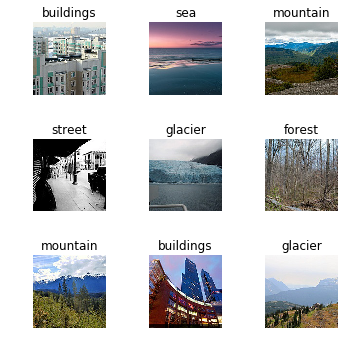

In [34]:
data.show_batch(rows=3, figsize=(5,5))

In [35]:
print(data.classes)
len(data.classes),data.c

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(6, 6)

## Training: resnet34
Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [36]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [37]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [38]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.516011,0.335960,0.114286,00:32
1,0.346199,0.287506,0.102209,00:31
2,0.260201,0.251921,0.087482,00:31
3,0.197871,0.235985,0.082769,00:31


In [39]:
learn.save('stage-1')

## Results

Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

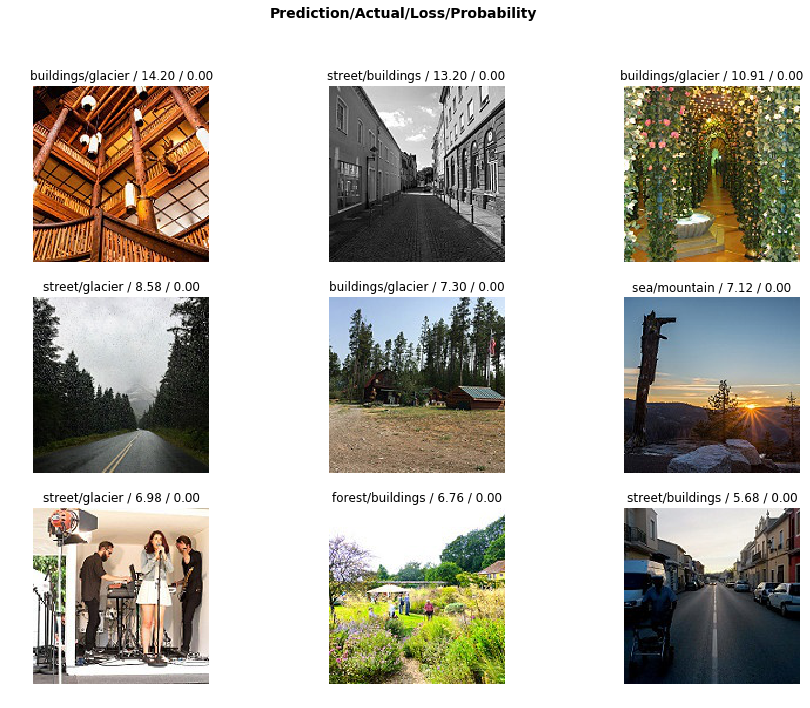

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

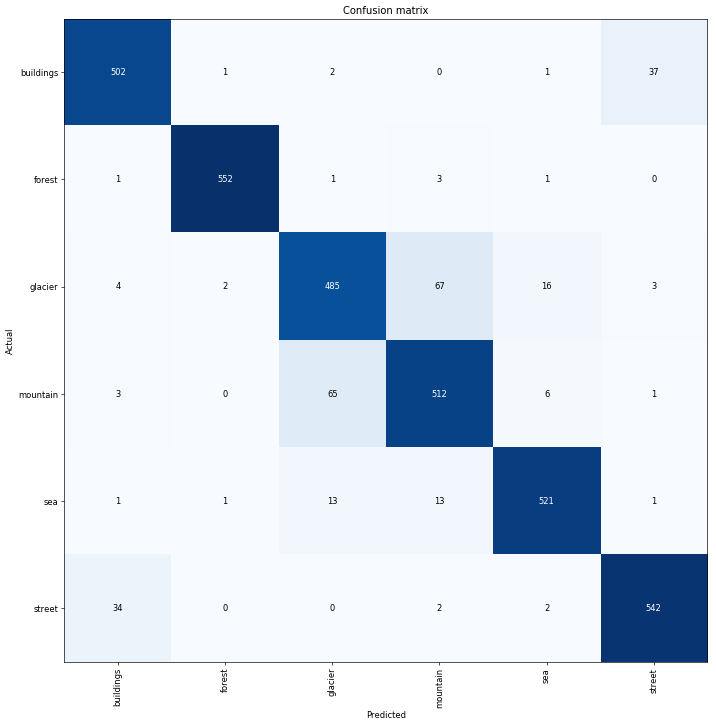

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interp.most_confused(min_val=2)

[('glacier', 'mountain', 67),
 ('mountain', 'glacier', 65),
 ('buildings', 'street', 37),
 ('street', 'buildings', 34),
 ('glacier', 'sea', 16),
 ('sea', 'glacier', 13),
 ('sea', 'mountain', 13),
 ('mountain', 'sea', 6),
 ('glacier', 'buildings', 4),
 ('forest', 'mountain', 3),
 ('glacier', 'street', 3),
 ('mountain', 'buildings', 3),
 ('buildings', 'glacier', 2),
 ('glacier', 'forest', 2),
 ('street', 'mountain', 2),
 ('street', 'sea', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


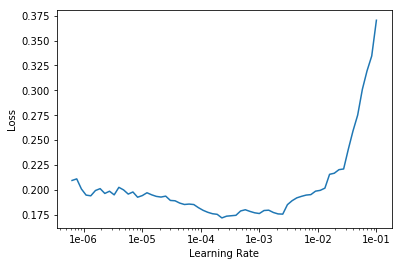

In [45]:
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.180391,0.226600,0.081296,00:34
1,0.157572,0.224987,0.077467,00:34
2,0.100857,0.227390,0.074521,00:33
3,0.079174,0.225703,0.073638,00:34


## Training: resnet50

In [48]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


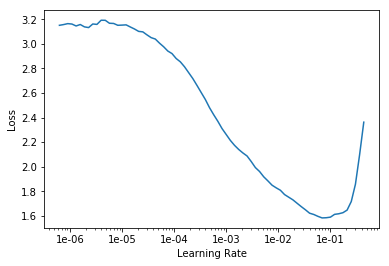

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.494904,0.379211,0.882769,00:37
1,0.342124,0.286935,0.897202,00:36
2,0.279311,0.258727,0.911929,00:36
3,0.207172,0.238684,0.926657,00:36
4,0.177251,0.230692,0.924890,00:36
5,0.111665,0.238256,0.926951,00:36
6,0.076564,0.233625,0.927835,00:37
7,0.068608,0.235739,0.927246,00:36


In [51]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [52]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.066227,0.236980,0.930486,00:47
1,0.055664,0.234590,0.931370,00:47
2,0.032784,0.238473,0.934021,00:47


In [53]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)